## Gaussian Processes for circuitpython and micopython

The following paragraph should run on boards with a rp2040 or nRF52840 chip. 
It allows the usage of simple 2D gaussian processes for parameter-free applications and mainly relys on ulab. If your microcontroller is able to handle the process depends on your data and mainly on the parametrization of your gaussian process. In general, it is recommended to avoid borderline cases.

Examples and working .py-scripts can be found in the examples folder.

**TO DO**

- add/implement additional kernel functions
- not sure but maybe 3D processes are possible (check ulab maximum number of dimensions)


In [1]:
try:
    from ulab import numpy as np
    #print('maximum number of dimensions: ', ulab.__version__)
except:
    import numpy as np
import random
import math
import time

def randoms(size):
    """
    returns a vector of random numbers.
    
    Args:
        size: 
            -vector size i.e. number of samples.
    Returns:
        vector of random numbers
    """
    return np.array([ random.random() for _ in range(size)  ])

def box_muller_1d(size):
    """
    Box muller method for random sampling.
    
    Args:
        dummy: 
            -size i.e. number of samples.
    Returns:
        samples
    """
    U1 = randoms(size)
    U2 = randoms(size)
    R = np.sqrt(-2 * np.log(U1))
    Theta = 2 * np.pi * U2
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    return X

def sample_gauss_box_mueller_1d(mu,sigma,size):
    """
    applies box muller to get gaussian distributions.
    
    Args:
        mu:
            -mean.
        sigma:
            -variance.
        size: 
            -size i.e. number of samples.
    Returns:
        samples
    """
    return box_muller_1d(size) * sigma + mu

def sample_multivariante_normal_1d(mu,K,epsilon=1e-5):
    """
    samples multivariante normal distributions.
    
    Args:
        mu:
            -mean.
        K:
            -kernel i.e. covariance matrix.
        epsilon: 
            -noise needed to solve cholesky.
    Returns:
        samples
    """
    
    d = len(mu)
    
    L = np.linalg.cholesky( matrix_sym(K) + epsilon*np.eye(d) )
    
    u = sample_gauss_box_mueller_1d(0, 1, d )
    mu1 = mu.transpose()
    return mu1 + np.dot(L, u)

def kernel_1d(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: 
            -Vector of m points.
        X2:
            -Vector of m points.
        l: 
            -Kernel length parameter.
            -Large and small values will/might cause numerical issues on your microcontroller.
            -use something like a mean diff from your training data
        sigma_f: 
            -Kernel vertical variation parameter.
            -Large values will/might cause numerical issues on your microcontroller.
    Returns:
        Kernel matrix.
    """
    sqdist = reshape( X1**2 ) + X2**2 - 2 * dotdot_1d( X1, X2 )
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def reshape(X):
    """
    reshapes a vector like numpy.reshape(-1,1)
    [a,b,c] --> [ [a],[b],[c] ]
    
    Args:
        X: 
            -vector
    Returns:
        reshaped vector
    """
    return np.array([[x] for x in X ])

def matrix_sym(X):
    """
    forces matrix symmetry.
    use when numerical errors occur.
    --> might not help
    
    Args:
        X: 
            -matrix
    Returns:
        symmetric matrix
    """
    for i,n1 in enumerate(X):
        for j,n2 in enumerate(n1):
            if i > j:
                X[j][i] = n2
    return X

def dotdot_1d(v1,v2):
    """
    dot product of two vectors
    
    Args:
        v1,v2: 
            -vectors
    Returns:
        matrix
    """
    dot = np.zeros( ( len(v1),len(v2) ) )
    for i,n1 in enumerate(v1):
        for j,n2 in enumerate(v2):
            dot[i][j] = n1*n2
    return dot

def posterior_1d(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, noise=0.0):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: 
            -New input locations numpy vector.
        X_train: 
            -Training locations numpy vector.
        Y_train: 
            -Training targets numpy vector.
        l: 
            -Kernel length parameter.
            -Large and small values will/might cause numerical issues on your microcontroller.
            -use something like a mean diff from your training data
        sigma_f: 
            -Kernel vertical variation parameter.
            -Large values will/might cause numerical issues on your microcontroller.
        noise:  
            -Noise parameter.
            -Large values will/might cause numerical issues on your microcontroller.

    Returns:
        Posterior mean vector and covariance matrix.
    """
    # variable noise
    K = kernel_1d(X_train, X_train, l, sigma_f) + noise**2 * np.eye(len(X_train))
    
    # hard coded noise... might be necessary for "creativity"
    # K = kernel_1d(X_train, X_train, l, sigma_f) + 0.1**2 * np.eye(len(X_train))

    # no noise
    # K = kernel_1d(X_train, X_train, l, sigma_f)
    
    K_s = kernel_1d(X_train, X_s, l, sigma_f)
    K_ss = kernel_1d(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    mu_s = np.dot(np.dot(K_s.transpose(),K_inv),Y_train)
    
    cov_s = K_ss - np.dot(np.dot(K_s.transpose(),K_inv),K_s)
    
    return mu_s, cov_s

def norm_samples(samples,lift=0.1):
    smin = np.min(samples)
    samples = samples - smin + 0.0
    smax = np.max(samples)
    samples = samples/smax
    return samples

# Finite number of points
X = np.arange( 0.1, 1.1, 0.02 )*10
Y_ref = np.sqrt(X)
#Y_ref = np.sin(X)
# Noise free training data
X_train = np.array([ 0.1, 0.3, 0.4,0.7 , 1])*10
Y_train = np.sqrt(X_train)

mean_diff = np.mean( np.diff(X_train) )
min_diff = np.min( np.diff(X_train) )
max_diff = np.max( np.diff(X_train) )
std_diff = np.std( np.diff(X_train) )
print(min_diff)
print(mean_diff," +/- ",std_diff) # ???
print(max_diff)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior_1d(X, X_train, Y_train, l=2.25, sigma_f=.5, noise=0.1)

samples = sample_multivariante_normal_1d( mu_s, cov_s, epsilon=1e-5 )

1.0
2.25  +/-  0.82915619758885
3.0


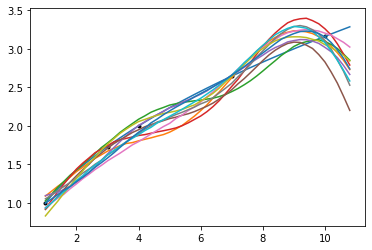

In [3]:
# this will obviously not run on your microcontroller...
# use it for visualization and testing

import matplotlib.pyplot as plt

plt.plot( X, Y_ref )
for _ in range(10):
    samples = sample_multivariante_normal_1d( mu_s, cov_s, epsilon=1e-5 )
    plt.plot( X, samples )
plt.plot( X_train, Y_train, ".k" )
plt.savefig("examples/example2.jpg")

In [ ]:
# copied from controller console output:
test = [5.91479e-06, 9.95073, 20.0382, 30.6792, 40.7753, 51.5722, 61.3831, 71.1688, 80.441, 88.7606, 96.4443, 103.472, 109.373, 115.238, 120.196, 124.923, 129.509, 133.644, 137.034, 140.633, 144.134, 148.536, 152.012, 156.26, 159.844, 164.236, 168.396, 173.082, 177.623, 184.116, 189.377, 194.726, 200.769, 206.058, 212.802, 219.181, 225.963, 231.396, 237.05, 242.182, 246.888, 250.699, 253.52, 255.359, 256.0, 255.345, 253.549, 250.41, 244.837, 238.489, 230.508]
plt.plot( np.arange( len(test) ), test )